In [15]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
from sklearn.metrics import classification_report, confusion_matrix

In [16]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Device:", device)

Device: cuda


In [17]:
DATA_DIR = 'C:/Users/NJS/Desktop/CVPR Final Assignment/ModifiedDataset'
TRAIN_DATA_DIR = os.path.join(DATA_DIR, 'Train')
TEST_DATA_DIR = os.path.join(DATA_DIR, 'Test')
IMG_SIZE = 255
BATCH_SIZE = 32
EPOCHS = 30

In [18]:
CATEGORIES = os.listdir(TRAIN_DATA_DIR)
print(CATEGORIES)

['Aurko', 'Masum', 'Shamim']


In [19]:
train_transforms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(20),
    transforms.RandomResizedCrop(IMG_SIZE, scale=(0.8, 1.0)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

test_transforms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])


In [20]:
train_dataset = datasets.ImageFolder(TRAIN_DATA_DIR, transform=train_transforms)
test_dataset = datasets.ImageFolder(TEST_DATA_DIR, transform=test_transforms)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True)

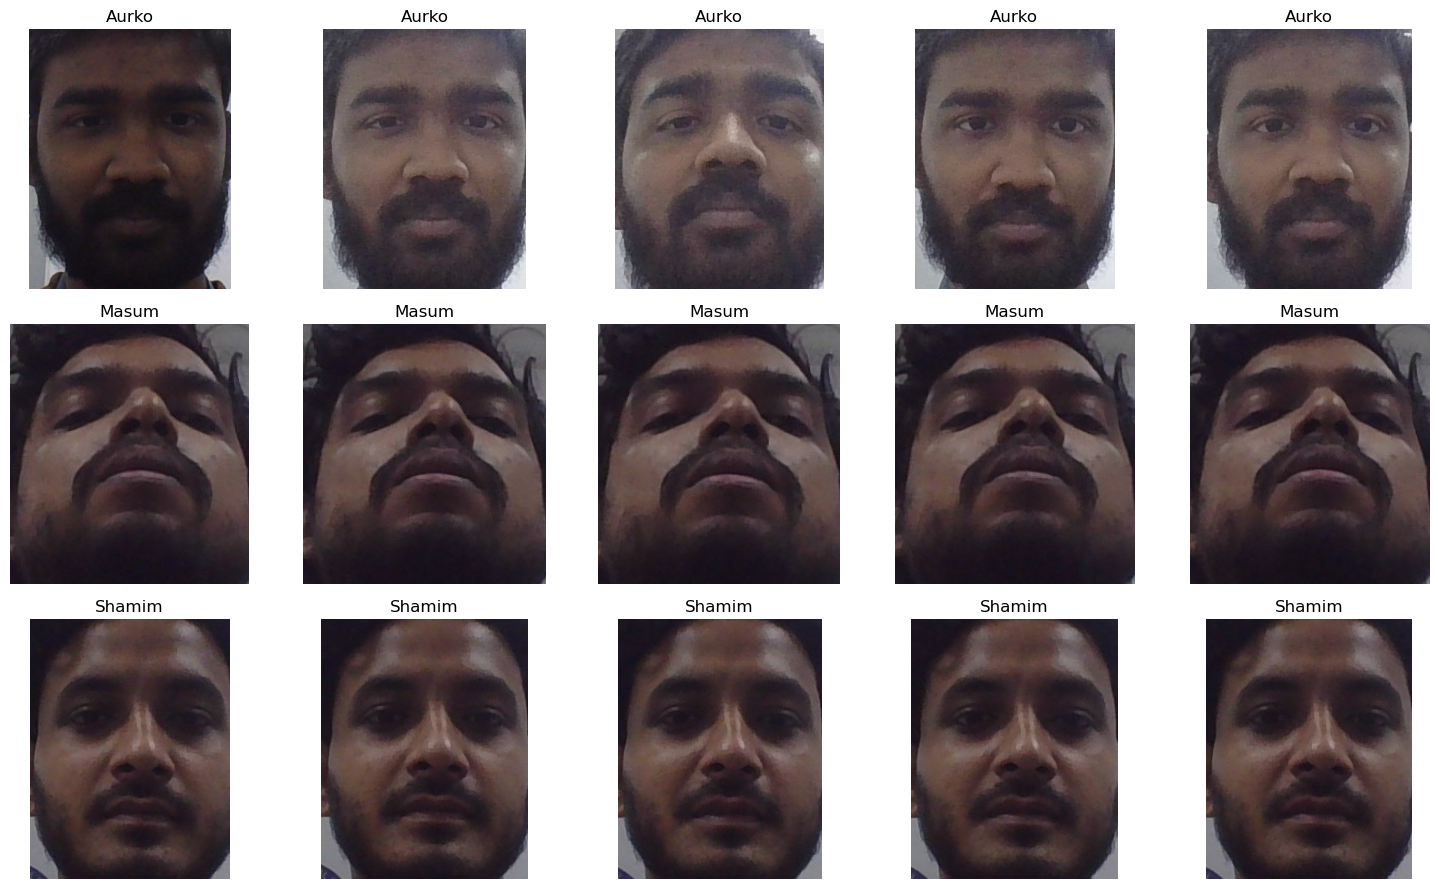

In [21]:
fig, axes = plt.subplots(len(CATEGORIES), 5, figsize=(15, 3 * len(CATEGORIES)))
for class_idx, class_name in enumerate(CATEGORIES):
    # Get indices of images belonging to the current class
    indices = [i for i, (_, label) in enumerate(train_dataset.samples) if label == class_idx]
    # Show up to 5 images per class
    for j in range(5):
        ax = axes[class_idx, j] if len(CATEGORIES) > 1 else axes[j]
        ax.axis('off')
        if j < len(indices):
            img_path, _ = train_dataset.samples[indices[j]]
            img = cv2.imread(img_path)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            ax.imshow(img)
            ax.set_title(class_name)
plt.tight_layout()
plt.show()

In [22]:
model = models.resnet50(pretrained=True)
for param in model.parameters():
    param.requires_grad = True

model.fc = nn.Sequential(
    nn.Linear(model.fc.in_features, 64),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(64, len(CATEGORIES))
)

model = model.to(device)

c:\Users\NJS\anaconda3\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\NJS\anaconda3\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [23]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.fc.parameters(), lr=0.01)

In [24]:
train_losses, val_losses, train_accuracies, val_accuracies = [], [], [], []

for epoch in range(EPOCHS):
    model.train()
    running_loss = 0
    correct = 0
    total = 0
    for images, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{EPOCHS}"):
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    train_loss = running_loss / len(train_loader)
    train_acc = correct / total
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)

    # Validation
    model.eval()
    val_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    val_loss /= len(test_loader)
    val_acc = correct / total
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)

    print(f"Train Acc: {train_acc:.4f}, Val Acc: {val_acc:.4f}")

Epoch 1/30: 100%|██████████| 12/12 [00:03<00:00,  3.79it/s]


Train Acc: 0.4972, Val Acc: 0.6000


Epoch 2/30: 100%|██████████| 12/12 [00:02<00:00,  4.39it/s]


Train Acc: 0.7639, Val Acc: 0.9000


Epoch 3/30: 100%|██████████| 12/12 [00:02<00:00,  4.42it/s]


Train Acc: 0.7667, Val Acc: 0.8111


Epoch 4/30: 100%|██████████| 12/12 [00:02<00:00,  4.36it/s]


Train Acc: 0.7528, Val Acc: 0.6556


Epoch 5/30: 100%|██████████| 12/12 [00:02<00:00,  4.46it/s]


Train Acc: 0.7944, Val Acc: 0.9333


Epoch 6/30: 100%|██████████| 12/12 [00:02<00:00,  4.43it/s]


Train Acc: 0.8167, Val Acc: 0.9778


Epoch 7/30: 100%|██████████| 12/12 [00:02<00:00,  4.40it/s]


Train Acc: 0.8194, Val Acc: 0.8556


Epoch 8/30: 100%|██████████| 12/12 [00:02<00:00,  4.41it/s]


Train Acc: 0.8111, Val Acc: 0.8111


Epoch 9/30: 100%|██████████| 12/12 [00:02<00:00,  4.47it/s]


Train Acc: 0.8389, Val Acc: 0.9778


Epoch 10/30: 100%|██████████| 12/12 [00:02<00:00,  4.41it/s]


Train Acc: 0.8222, Val Acc: 0.9111


Epoch 11/30: 100%|██████████| 12/12 [00:02<00:00,  4.34it/s]


Train Acc: 0.8222, Val Acc: 0.9222


Epoch 12/30: 100%|██████████| 12/12 [00:02<00:00,  4.36it/s]


Train Acc: 0.8528, Val Acc: 0.9556


Epoch 13/30: 100%|██████████| 12/12 [00:02<00:00,  4.39it/s]


Train Acc: 0.7944, Val Acc: 0.8222


Epoch 14/30: 100%|██████████| 12/12 [00:02<00:00,  4.41it/s]


Train Acc: 0.8500, Val Acc: 0.9333


Epoch 15/30: 100%|██████████| 12/12 [00:02<00:00,  4.45it/s]


Train Acc: 0.8389, Val Acc: 0.8889


Epoch 16/30: 100%|██████████| 12/12 [00:02<00:00,  4.46it/s]


Train Acc: 0.7833, Val Acc: 0.9556


Epoch 17/30: 100%|██████████| 12/12 [00:02<00:00,  4.39it/s]


Train Acc: 0.7889, Val Acc: 0.9111


Epoch 18/30: 100%|██████████| 12/12 [00:02<00:00,  4.29it/s]


Train Acc: 0.8278, Val Acc: 0.9000


Epoch 19/30: 100%|██████████| 12/12 [00:02<00:00,  4.41it/s]


Train Acc: 0.7472, Val Acc: 0.9000


Epoch 20/30: 100%|██████████| 12/12 [00:02<00:00,  4.39it/s]


Train Acc: 0.7889, Val Acc: 0.9111


Epoch 21/30: 100%|██████████| 12/12 [00:02<00:00,  4.32it/s]


Train Acc: 0.7694, Val Acc: 0.9222


Epoch 22/30: 100%|██████████| 12/12 [00:02<00:00,  4.32it/s]


Train Acc: 0.7806, Val Acc: 0.8556


Epoch 23/30: 100%|██████████| 12/12 [00:02<00:00,  4.39it/s]


Train Acc: 0.6944, Val Acc: 0.8889


Epoch 24/30: 100%|██████████| 12/12 [00:02<00:00,  4.42it/s]


Train Acc: 0.6750, Val Acc: 0.8667


Epoch 25/30: 100%|██████████| 12/12 [00:02<00:00,  4.41it/s]


Train Acc: 0.7472, Val Acc: 0.9111


Epoch 26/30: 100%|██████████| 12/12 [00:02<00:00,  4.39it/s]


Train Acc: 0.8000, Val Acc: 0.9444


Epoch 27/30: 100%|██████████| 12/12 [00:02<00:00,  4.46it/s]


Train Acc: 0.7722, Val Acc: 0.9444


Epoch 28/30: 100%|██████████| 12/12 [00:02<00:00,  4.49it/s]


Train Acc: 0.7889, Val Acc: 0.9111


Epoch 29/30: 100%|██████████| 12/12 [00:02<00:00,  4.45it/s]


Train Acc: 0.6944, Val Acc: 0.9333


Epoch 30/30: 100%|██████████| 12/12 [00:02<00:00,  4.39it/s]


Train Acc: 0.6250, Val Acc: 0.9778


In [25]:
torch.save(model.state_dict(), 'final_ResNet_model.pth')

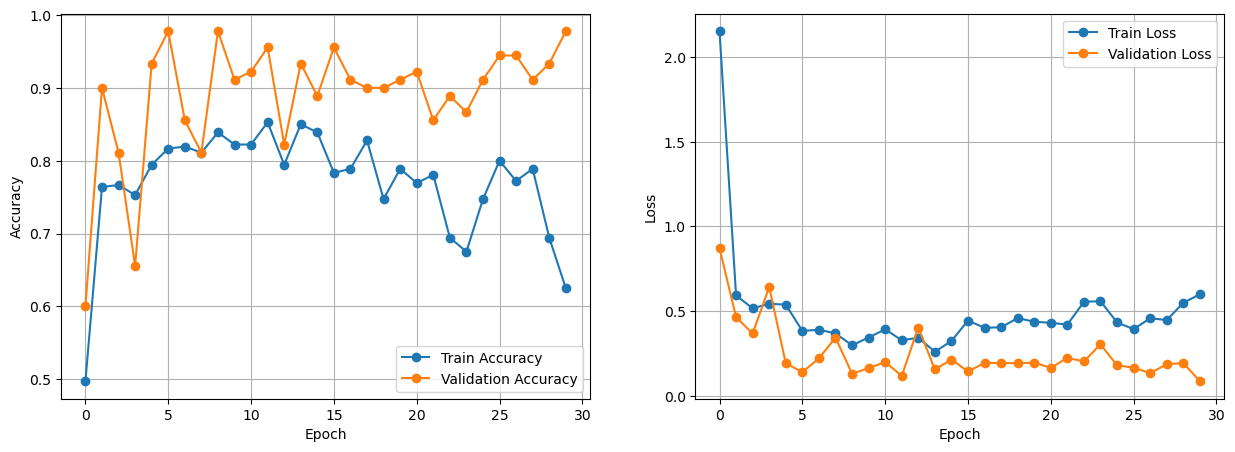

Classification Report:
              precision    recall  f1-score   support

       Aurko       1.00      1.00      1.00        30
       Masum       1.00      0.93      0.97        30
      Shamim       0.94      1.00      0.97        30

    accuracy                           0.98        90
   macro avg       0.98      0.98      0.98        90
weighted avg       0.98      0.98      0.98        90

Confusion Matrix:
[[30  0  0]
 [ 0 28  2]
 [ 0  0 30]]


In [26]:
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.plot(train_accuracies, 'o-', label='Train Accuracy')
plt.plot(val_accuracies, 'o-', label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.subplot(1,2,2)
plt.plot(train_losses, 'o-', label='Train Loss')
plt.plot(val_losses, 'o-', label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

# Evaluate
model.eval()
y_true = []
y_pred = []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())

print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=CATEGORIES))
print("Confusion Matrix:")
print(confusion_matrix(y_true, y_pred))


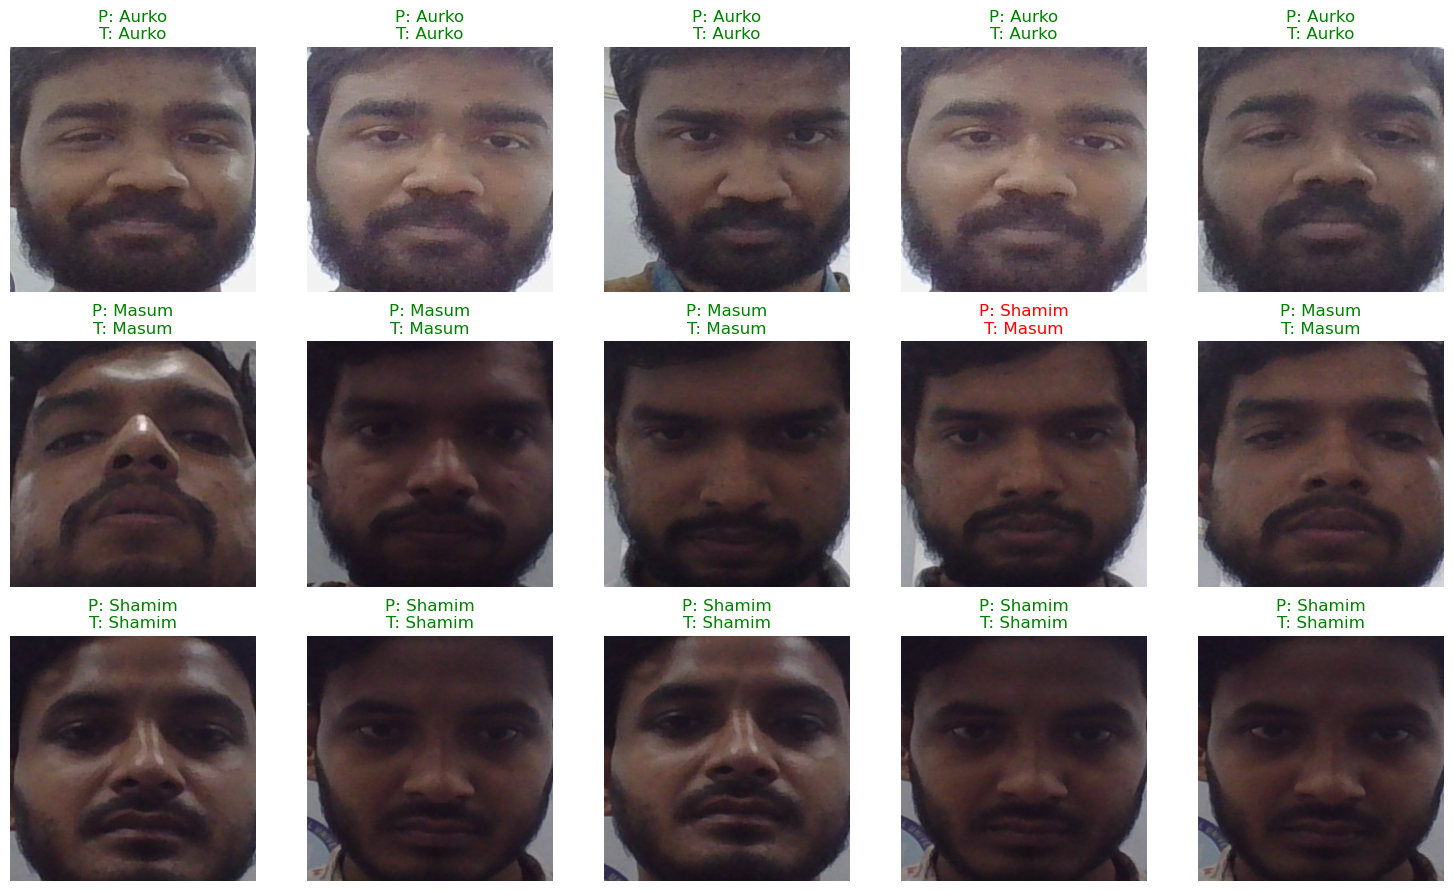

In [27]:
model.eval()
class_images = {cls: [] for cls in CATEGORIES}

# Collect up to 5 images per class from the test set
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        for img, label, pred in zip(images, labels, preds):
            cls_name = CATEGORIES[label.item()]
            if len(class_images[cls_name]) < 5:
                class_images[cls_name].append((img.cpu(), label.item(), pred.item()))
        if all(len(imgs) >= 5 for imgs in class_images.values()):
            break

plt.figure(figsize=(15, 3 * len(CATEGORIES)))
for idx, cls in enumerate(CATEGORIES):
    for j, (img, label, pred) in enumerate(class_images[cls]):
        ax = plt.subplot(len(CATEGORIES), 5, idx * 5 + j + 1)
        img_np = img.permute(1, 2, 0).numpy()
        img_np = np.clip(img_np * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406]), 0, 1)
        plt.imshow(img_np)
        true_label = CATEGORIES[label]
        pred_label = CATEGORIES[pred]
        color = 'green' if true_label == pred_label else 'red'
        plt.title(f"P: {pred_label}\nT: {true_label}", color=color)
        plt.axis('off')
plt.tight_layout()
plt.show()